### Figures and plots for experiments with U-Net on sea level pressure (SLP) data from CESM

Try U-Net following [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x), but with only 4 convolutions, opposed to 5. Work with CESM slp samples.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data, 
    get_land_silhouette,
)
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

### Show exemplary input samples with corresponding targets

In [3]:
## Re-load validation samples:

path_to_data = 'climate_index_collection/data/raw/2022-08-22/' # Path to full data.
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'fixed' # Can have random mask for missing values, individually for each data sample ('variable').
                    # Or create only a single random mask, that is then applied to all samples identically ('fixed').
missing_type = 'discrete' # Either specify a discrete amount of missing values ('discrete') or give a range ('range').
                          # Giving a range only makes sense for mask_type='variable'.
missing_min=0.95 # Specify the range of allowed relative amounts of missing values.                
missing_max=0.95 # For mask_type='fixed', both values are set identically and give the desired amount of missing values.
seed = 1 # Seed for random number generator, for reproducibility.
train_val_split = 0.8 # Set relative amount of training data.
scale_to = 'zero_one' # Specify the desired scaling. Choose to scale inputs to [-1,1] ('one_one') or [0,1] ('zero_one') 
                      # or 'norm' to normalize inputs or 'no' to omit scaling.        
        
# Load data:
data = load_data_set(data_path=path_to_data, data_source_name=source)

# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature=feature, data_set=data)

# Create mask for missing values:
missing_mask = create_missing_mask(
    data=data,
    mask_type=mask_type,
    missing_type=missing_type,
    missing_min=missing_min,
    missing_max=missing_max,
    seed=seed,
)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
_, val_input, _, val_target, train_min, train_max, _, _ = split_and_scale_data(
    data, 
    missing_mask,
    train_val_split, 
    scale_to
)

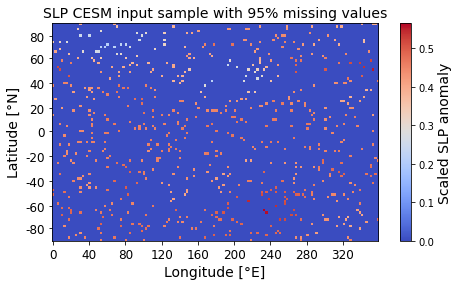

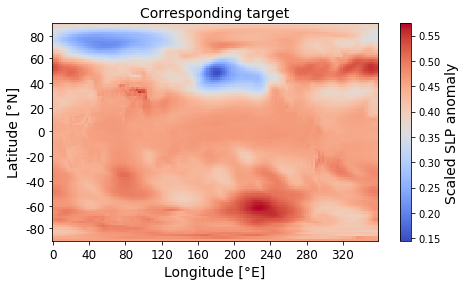

In [6]:
# Plot first validation input:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(val_input[0],axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('Scaled SLP anomaly', fontsize=14)
plt.title('SLP CESM input sample with 95% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot corresponding target:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(val_target[0],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.0)
cbar = plt.colorbar(im)
cbar.set_label('Scaled SLP anomaly', fontsize=14)
plt.title('Corresponding target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

### Compare loss for different model setups

See notebook: **01a_unet_4conv_slp_CESM_compare_loss_sensitivity.ipynb**

### Sensitivity experiment

See notebook: **01a_unet_4conv_slp_CESM_compare_loss_sensitivity.ipynb**

### Compare loss of models trained on discrete rates of missing values to model trained on whole range

See notebook: **02a_unet_4conv_slp_CESM_range.ipynb**

### Show reconstruction of final models on single validation samples for 99.9% and 99% of missing values

Note: Exclude range model ('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/')

In [5]:
# Set paths to final models:
paths_string = [
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_fixed_discrete_factor_1_final/',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_discrete_factor_1_final/',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_discrete_factor_2_final/',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_discrete_factor_3_final/',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_optimal_discrete_factor_1_final/',
]

model_labels = [
    'mask: fixed',
    'mask: var./disc., augm. factor: 1',
    'mask: var./disc., augm. factor: 2',
    'mask: var./disc., augm. factor: 3',
    'mask: optimal',
]

# Set corresponding augmentation factors, for restoring inputs and targets:
augmentation_factors = [1,1,2,3,1]

In [6]:
# Set rates of missing values:
missing_values = [0.999, 0.99]

# Set number of validation samples to predict on:
n_samples = 4 # Keep in mind, that we might have data augmentation, hence several similar targets. 

# Initialize storage for validation inputs, targets and model predictions. 
# Dimension: (#rates of missing values, #models, #samples, lat, lon)
val_input_all = np.zeros((len(missing_values),len(paths_string),n_samples,data.shape[1],data.shape[2]))
val_target_all = np.zeros((len(missing_values),len(paths_string),n_samples,data.shape[1],data.shape[2]))
val_pred_all = np.zeros((len(missing_values),len(paths_string),n_samples,data.shape[1],data.shape[2]))

# Run over rates of missing values:
for i in range(len(missing_values)):
    
    # Print status:
    print("missing values: ",i+1," of ",len(missing_values))
    
    # Get current rate of missing values:
    missing = missing_values[i]

    # Run over desired final models:
    for j in range(len(paths_string)):
        
        # Print status:
        print("  models: ",j+1," of ",len(paths_string))
    
        ## Reload missing mask for current final model and current rate of missing values:

        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            missing_mask = np.load(
                Path(paths_string[j]) / "missing_" f"{int(missing*1000)}" / "missing_mask.npy"
            )
        else:
            missing_mask = np.load(
                Path(paths_string[j]) / "missing_" f"{int(missing*100)}" / "missing_mask.npy"
            )
        
        # Extend data, according to augmentation factor:
        data_extended = clone_data(data=data, augmentation_factor=augmentation_factors[j])
            
        # Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
        # identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
        _, val_input, _, val_target, train_min, train_max, _, _ = split_and_scale_data(
            data_extended, 
            missing_mask,
            train_val_split, 
            scale_to
        )
        
        # Store targets:
        val_target_all[i,j] = val_target[:n_samples]
        
        ## Reload current model for current rate of missing values:

        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            model = tf.keras.models.load_model(
                Path(paths_string[j]) / "missing_" f"{int(missing*1000)}" / "model"
            )
        else:
            model = tf.keras.models.load_model(
                Path(paths_string[j]) / "missing_" f"{int(missing*100)}" / "model"
            )
            
        # Get model predictions on desired number of validation inputs:
        val_pred = model.predict(val_input[:n_samples])

        # Store inputs and predictions (omit final dimension for channel, which is one):
        val_input_all[i,j] = val_input[:n_samples,:,:,0]
        val_pred_all[i,j] = val_pred[:n_samples,:,:,0]
        
        

val_target_all.shape

missing values:  1  of  2
  models:  1  of  5


2023-02-02 19:41:52.594681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-02 19:41:52.594705: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 19:41:52.594719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl204): /proc/driver/nvidia/version does not exist
2023-02-02 19:41:52.594941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 19:41:53.861481: I tensorflow/compile

  models:  2  of  5
  models:  3  of  5
  models:  4  of  5
  models:  5  of  5
missing values:  2  of  2
  models:  1  of  5
  models:  2  of  5
  models:  3  of  5
  models:  4  of  5
  models:  5  of  5


(2, 5, 4, 96, 144)

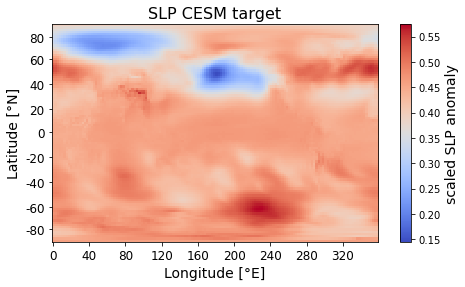

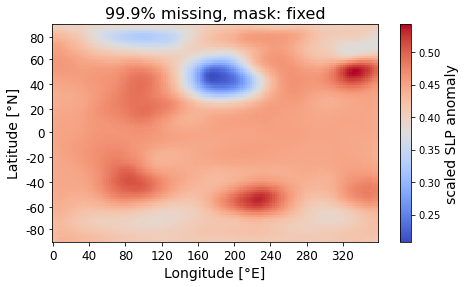

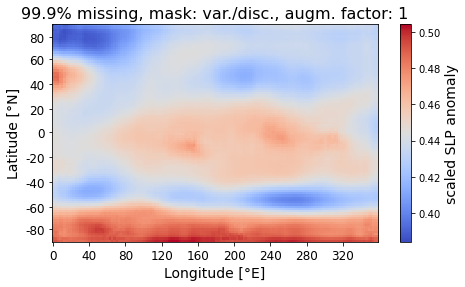

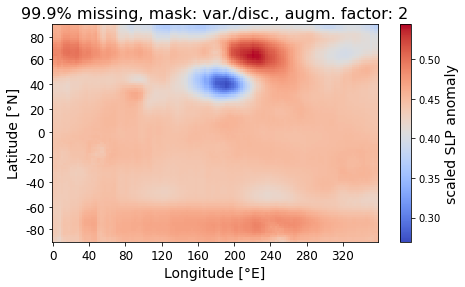

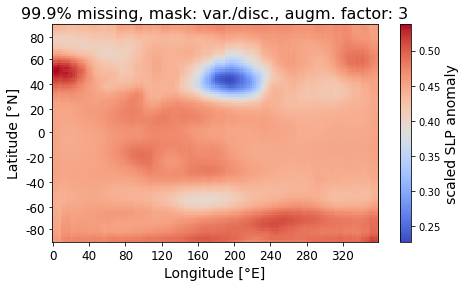

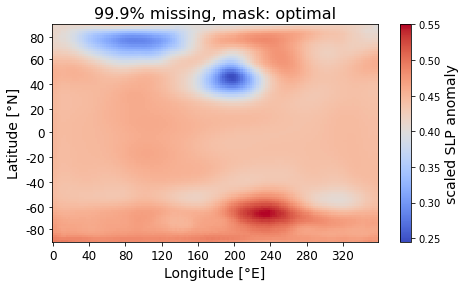

In [8]:
# Pick sample:
sample = 0

# Set rate of missing values:
missing = 0

# Plot exemplary target:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(val_target_all[0,0,0],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.0)
cbar = plt.colorbar(im)
cbar.set_label('scaled SLP anomaly', fontsize=14)
plt.title('SLP CESM target', fontsize=16)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

## Plot model reconstruction for several final models:

# Run over models:
for j in range(len(paths_string)):

    # Plot reconstruction from current model:
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(np.flip(val_pred_all[missing,j,sample],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.0)
    cbar = plt.colorbar(im)
    cbar.set_label('scaled SLP anomaly', fontsize=14)
    plt.title(str(missing_values[missing]*100)+'% missing, '+model_labels[j], fontsize=16)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

### Show mean rel. loss reduction maps and optimal fixed masks

See notebook: **03a_unet_4conv_slp_CESM_relevance_maps.ipynb**

### EOF analysis for SLP anomaly fields

See notebook: **04a_slp_CESM_EOF_analysis.ipynb**